In [662]:
%matplotlib inline

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import math
import pytesseract
import re

from functools import partial
import concurrent.futures

In [663]:
%run four_point_transform.py

In [664]:
GREEN = (0, 255, 0)
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)

In [665]:
def draw(img):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')
    
def Gray(img):
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

def TopHat(img, size=(9, 9)):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, size)
    return cv.morphologyEx(img, cv.MORPH_TOPHAT, kernel)

def Open(img, size=(9, 9)):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, size)
    return cv.morphologyEx(img, cv.MORPH_OPEN, kernel)

def Close(img, size=(9, 9)):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, size)
    return cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)

def AdaptiveThreshold(img):
    thresh = cv.adaptiveThreshold(img, 255, 
                                  cv.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  thresholdType=cv.THRESH_BINARY_INV,
                                  blockSize=9,
                                  C=5)
    return thresh

def Otsu(img):
    thresh = cv.threshold(img, 0, 255, cv.THRESH_BINARY|cv.THRESH_OTSU)[1]
    return thresh

def Inverse(img):
    return cv.bitwise_not(img)

def Canny(img):
    return cv.Canny(thresh, 50, 200, None, 3)

def Dilate(img, size=(3, 3), kernel=None):
    if kernel is None:
        kernel = cv.getStructuringElement(cv.MORPH_RECT, size)
    return cv.dilate(img, kernel)

def Erode(img, size=(5, 5), kernel=None):
    if kernel is None:
        kernel = cv.getStructuringElement(cv.MORPH_RECT, size)
    return cv.erode(img, kernel)

# nonzeros = cv.findNonZero(thresh)
def MedianBlur(src, size=5):
    return cv.medianBlur(src, size)

def MinAreaRect(contour):
    rect = cv.minAreaRect(contour)
    box = cv.boxPoints(rect)
    cnt = np.int0(box)
    return cnt

# vis = cv.drawContours(img.copy(), [cnt], -1, (0, 255, 0), 1)
# draw(vis)

def FindOuterContour(thresh):
    cnts, _ = cv.findContours(thresh,
                              cv.RETR_LIST,
                              cv.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, 
                  key=cv.contourArea, 
                  reverse=True)
    cnt = None
    for c in cnts:
        # Approximate the contour.
        peri = cv.arcLength(c, True)
        approx = cv.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            cnt = approx
            break
    return cnt

def DrawContour(img, cnts, color=GREEN, width=3):
    draw(cv.drawContours(img.copy(), cnts, -1, color, width))
    
# def sobelxy(img, ksize=5):
#     sobelx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize)  # x
#     sobely = cv.Sobel(sobelx, cv.CV_64F, 0, 1, ksize)  # y
#     return sobely

def HoughLines(src, color=GREEN, width=2, threshold=200):
    # rho in pixels.
    rho = 1

    # theta in degree.
    theta = np.pi/180

    # The minimum number of intersections to detect a line.
#     threshold = 200

    lines = cv.HoughLines(src, rho, theta, threshold, None, 0, 0)
    if lines is not None:
        for rho, theta in lines[:, 0]:
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

            cv.line(src, pt1, pt2, color, width, cv.LINE_AA)
    return src


def HoughLinesP(img, color=(255, 255, 255), width=1):
    minLineLength = img.shape[1] * 0.2
    maxLineGap = 10
    lines = cv.HoughLinesP(img, 1, np.pi/180, 100, minLineLength, maxLineGap)
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv.line(img, (x1,y1), (x2,y2), color, width)
    return img

def Laplacian(img):
    laplacian = cv.Laplacian(img, cv.CV_8UC1) # Laplacian Edge Detection
    return laplacian

def Sobel(src):    
    # Sobel on the x-axis helps remove vertical line.
    grad_x = cv.Sobel(src, ddepth=cv.CV_32F, dx=1, dy=0, ksize=-1)
    abs_grad_x = cv.convertScaleAbs(grad_x)
    abs_grad_x = cv.normalize(abs_grad_x, abs_grad_x, 255, 0)

    # Sobel on the y-axis helps remove vertical line.
    grad_y = cv.Sobel(src, ddepth=cv.CV_32F, dx=0, dy=1, ksize=-1)
    abs_grad_y = cv.convertScaleAbs(grad_y)    
    abs_grad_y = cv.normalize(abs_grad_y, abs_grad_y, 255, 0)

    sobel = cv.bitwise_and(abs_grad_x, abs_grad_y)
    return cv.bitwise_and(sobel, src)

def GaussianBlur(src, size=(3, 3)):
    return cv.GaussianBlur(src, size, -1)

def FloodFill(src, point=(0, 0), color=(0, 0, 0)):
    return cv.floodFill(src, None, point, color)[1]

def ConnectedComponents(src, min_area=10):
    nlabel, labels, stats, centroids = cv.connectedComponentsWithStats(src, connectivity=8)
    for l in range(1, nlabel):
        area = stats[l, cv.CC_STAT_AREA]
        if area <= min_area:
            # CC_STAT_TOP
            # CC_STAT_WIDTH
            # CC_STAT_HEIGHT
            # CC_STAT_AREA
            l, t = stats[l, cv.CC_STAT_LEFT], stats[l, cv.CC_STAT_TOP]
            src = FloodFill(src, point=(t, l), color=(0, 0, 0))
    return src

In [666]:
def match_int(s):
    match = re.match('\d+', s)
    if match is None:
        return -1
    return int(match.group(0))

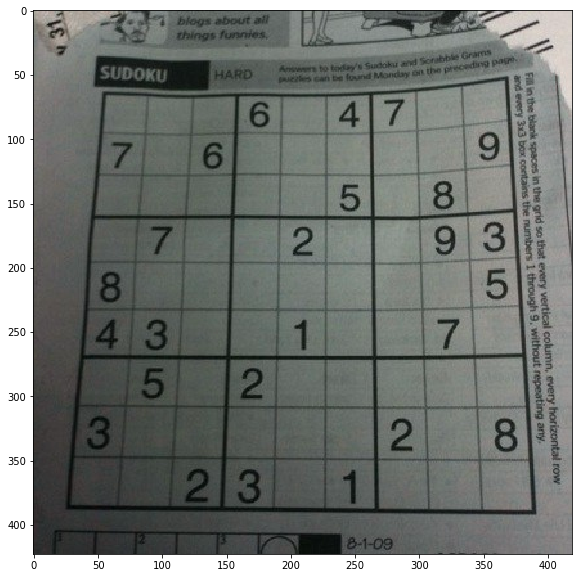

In [667]:
src = 'sudoku.jpeg'
# src = 'sudoku_1.png'
# src = 'sudoku_2.png'
# src = 'sudoku_3.png'

img = cv.imread(src)

draw(img)

In [668]:
class Pipeline:
    def __init__(self, pipelines):
        self.pipelines = pipelines
    def exec(self, src):
        dst = src.copy()
        self.steps = {}
        for name, fn in self.pipelines:
            dst = fn(dst)
            self.steps[name] = dst.copy()
        return dst

(52, 27) [[369  52]
 [ 55  63]
 [ 27 387]
 [390 392]] 52 27


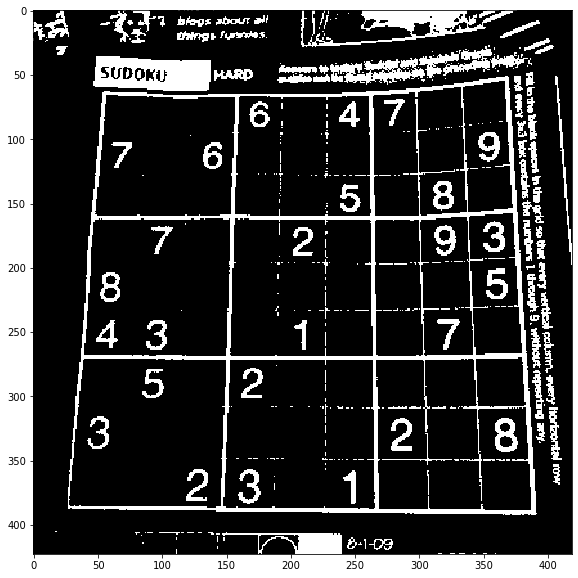

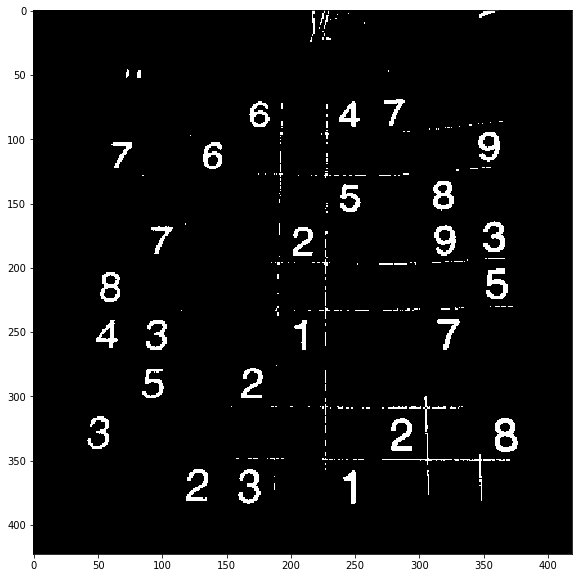

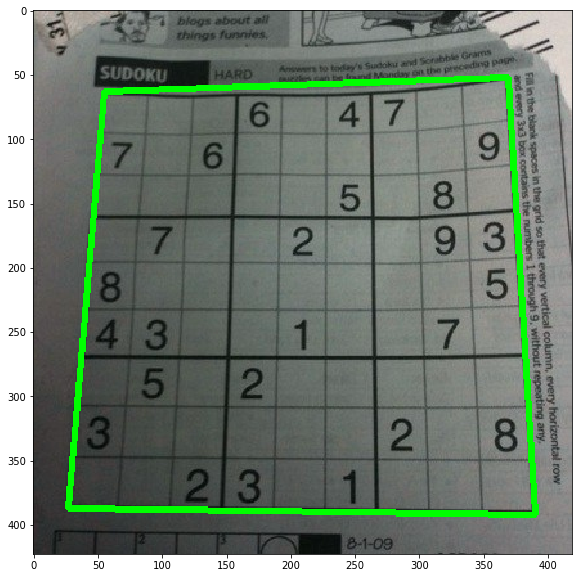

In [669]:
height, width = img.shape[:2]

# Assuming user takes the full photo of sudoku - so the whole grid fits into
# the picture. Since it's a square, take the minimum dimension. 
# Assume that the box fit to at least 80% of the image (the Pareto's Principle).
dim = min(height, width) * 0.8


# Divide it by 9 since one row/column will have 9 cells. 
# Use that as the kernel size.
cell = int(dim / 9) # Equivalent to math.ceil.

pipeline = Pipeline([('gray', Gray),
                     ('inverse', Inverse),
#                      ('blur', MedianBlur),
                     # We want to use tophat to capture only the grid - 
                     # anything larger than it will be excluded.
                     ('tophat', partial(TopHat, size=(cell, cell))),
                     ('thresh', Otsu),
                     ('floodfill', FloodFill),
                    ])

dst = pipeline.exec(img)
draw(dst)
cnt = FindOuterContour(dst)

if cnt is not None:
    if cv.contourArea(cnt) < 0.5 * width * 0.5 * height:
        cnt = None
    else:
        points = cnt.reshape(4, 2)
        left = min(points[:,1])
        top = min(points[:,0])
        lefttop = (left, top)
        print(tuple(lefttop), points, left, top)
        dst = FloodFill(dst, point=lefttop, color=(255, 255, 255))
        dst = FloodFill(dst, point=lefttop, color=(0, 0, 0))
        # print(cnt.shape, [a[0] for a in cnt])
    #     dst FloodFill
        draw(dst)
if cnt is not None:
    DrawContour(img.copy(), [cnt])

contour [[[369  52]]

 [[ 55  63]]

 [[ 27 387]]

 [[390 392]]]
[[ 55.  63.]
 [369.  52.]
 [390. 392.]
 [ 27. 387.]]


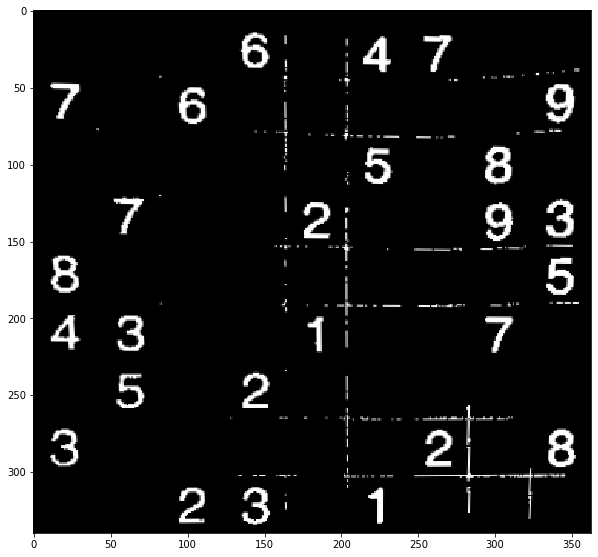

In [670]:
if cnt is not None:
    print('contour', cnt)
    transform = four_point_transform(dst, cnt.reshape(4, 2))
#     h, w = transform.shape[:2]
#     draw(FloodFill(transform))
    draw(transform)
else:
    transform = dst

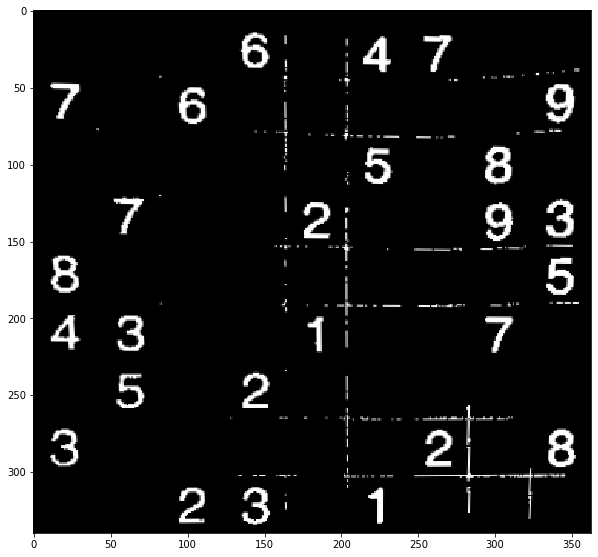

In [671]:
clear = transform.copy()
height, width = clear.shape[:2]
epoch = 0
while True:
    contours, _ = cv.findContours(clear, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv.contourArea, reverse=True)
    if not contours: break
    if cv.contourArea(contours[0]) / (height * width) < 0.9: break
    clear = cv.drawContours(clear, [contours[0]], -1, (0, 0, 0), 5)
    print('iterating', epoch)
    epoch += 1
draw(clear)

dim 272.0
cell 30
cell area 900
font 15
erosion_size 8


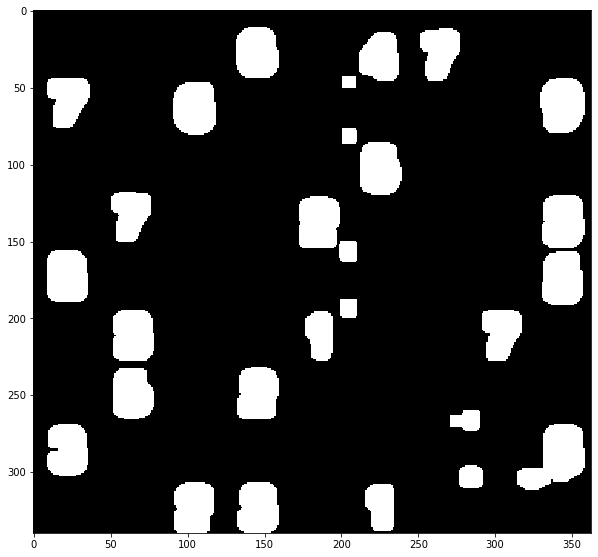

In [672]:
# Take full dim now that we have transformed the image to fit full screen.
height, width = transform.shape[:2]
dim = min(height, width) * 0.8

erosion_size = int(dim/100*3) # 3px erosion for 100px size.

# Divide it by 9 since one row/column will have 9 cells. 
# Use that as the kernel size.
cell = int(dim / 9) # Equivalent to math.ceil.
font = int(cell / 2) # Assume the font is just 50% of the cell width.

print('dim', dim)
print('cell', cell)
print('cell area', cell * cell)
print('font', font)
print('erosion_size', erosion_size)

pipeline2 = Pipeline([#('hough', partial(HoughLines, color=BLACK, width=3, threshold=200)),
                      ('blur',  partial(GaussianBlur, size=(font, font))),
                      ('thresh', Otsu),
                      ('connected', partial(ConnectedComponents, min_area=cell * cell)),
                      ('tophat', partial(TopHat, size=(cell, cell))),
#                       ('sobel', Sobel),
                      ('open', partial(Close, size=(erosion_size, erosion_size))),
                      ('open', partial(Dilate, size=(erosion_size, erosion_size))),
                      ('thresh', Otsu),
])

out = pipeline2.exec(transform)

#         print(labels[l], stats[l], centroids[l])
# for i in range(1, 9):
#     w = int(width / 9) * i
#     h = int(height / 9) * i
#     # Draw horizontal line.
#     out = cv.line(out, (0, h), (width, h), (0, 0, 0), 3)
    
#     # Draw vertical line.
#     out = cv.line(out, (w, 0), (w, height), (0, 0, 0), 3)

draw(out)

22


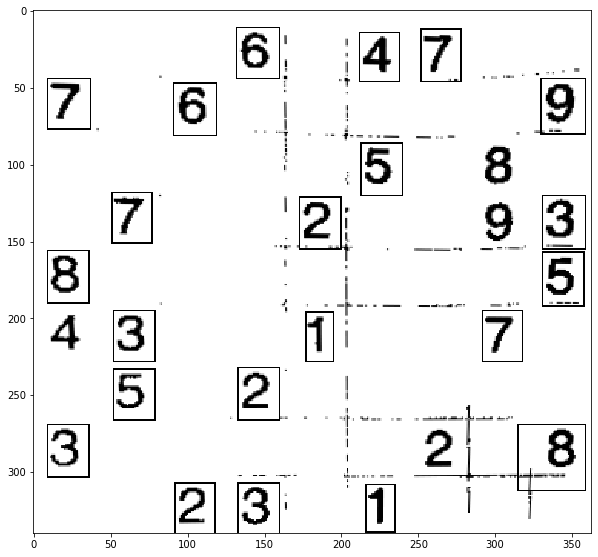

In [673]:
tgt = Inverse(transform)

cnts, _ = cv.findContours(out, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = [c for c in cnts
        if cv.contourArea(c) > cell*cell/4]
# grid = [MinAreaRect(c) 
#         for c in cnts]

vis = tgt.copy()
for c in cnts:
    x, y, w, h = cv.boundingRect(c)
    cv.rectangle(vis, (x, y),(x + w, y + h), GREEN, 1)

print(len(cnts))
draw(vis)

In [674]:
%%time

# Remove border.
rois = []
height, width = tgt.shape[:2]

# Additional padding which is the border.
p = 2

def analyze_contour(c):
    x, y, w, h = cv.boundingRect(c)
    # The region of interest.
    roi = tgt[max(0, y-p):min(y+h+p, height), max(0, x-p):min(x+w+p, width)]

    # Set edges to white.
    roi[:, 0] = 255
    roi[:, -1] = 255
    roi[0, :] = 255
    roi[-1, :] = 255
    rois.append(roi)

    text = pytesseract.image_to_string(roi, config='--oem 1 --psm 6') # Needs to be enabled to read single digit.
    out = match_int(text)
#         if out == -1: return (-1, -1, -1)

    mid_x = x + (w / 2)
    mid_y = y + (h / 2)
    i, j = int(mid_y/height * 9), int(mid_x/width * 9)
    return (i, j, out)

# Faster than process pool executor.
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    sudoku = np.zeros((9, 9), np.int)
    for i, j, val in executor.map(analyze_contour, cnts):
        if val < 0 or val > 9: continue
        sudoku[i, j] = val

CPU times: user 105 ms, sys: 193 ms, total: 298 ms
Wall time: 5.41 s


In [675]:
len(sudoku[sudoku > 0])

22

In [676]:
sudoku

array([[0, 0, 0, 6, 0, 4, 7, 0, 0],
       [7, 0, 6, 0, 0, 0, 0, 0, 9],
       [0, 0, 0, 0, 0, 5, 0, 0, 0],
       [0, 7, 0, 0, 2, 0, 0, 0, 3],
       [8, 0, 0, 0, 0, 0, 0, 0, 5],
       [0, 3, 0, 0, 1, 0, 0, 7, 0],
       [0, 5, 0, 2, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0, 0, 0, 8],
       [0, 0, 2, 3, 0, 1, 0, 0, 0]])

In [677]:
%run sudoku.py

<Figure size 432x288 with 0 Axes>

In [678]:
solver = SudokuSolver()
result = solver(sudoku)
print(result)

[[5. 9. 3. 6. 8. 4. 7. 2. 1.]
 [7. 4. 6. 1. 3. 2. 5. 8. 9.]
 [2. 1. 8. 7. 9. 5. 3. 6. 4.]
 [1. 7. 4. 5. 2. 6. 8. 9. 3.]
 [8. 2. 9. 4. 7. 3. 6. 1. 5.]
 [6. 3. 5. 8. 1. 9. 4. 7. 2.]
 [9. 5. 7. 2. 4. 8. 1. 3. 6.]
 [3. 6. 1. 9. 5. 7. 2. 4. 8.]
 [4. 8. 2. 3. 6. 1. 9. 5. 7.]]
